## Work on real Merian image
Several updates:


In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [116]:
obj_cat = Table.read('./Cutout/stars/stars-2022-04-25.fits')
obj_cat['id'] = obj_cat['name']

In [117]:
obj_cat

<Table length=500>
 name     prefix    ... half_size   id  
                    ...   arcsec        
int64    bytes12    ...  float64  int64 
------ ------------ ... --------- ------
  1832   stars_1832 ...      10.0   1832
  2434   stars_2434 ...      10.0   2434
  2748   stars_2748 ...      10.0   2748
  4699   stars_4699 ...      10.0   4699
  5001   stars_5001 ...      10.0   5001
  5822   stars_5822 ...      10.0   5822
  6013   stars_6013 ...      10.0   6013
  6478   stars_6478 ...      10.0   6478
  6585   stars_6585 ...      10.0   6585
   ...          ... ...       ...    ...
293627 stars_293627 ...      10.0 293627
293952 stars_293952 ...      10.0 293952
294449 stars_294449 ...      10.0 294449
295686 stars_295686 ...      10.0 295686
295711 stars_295711 ...      10.0 295711
295938 stars_295938 ...      10.0 295938
296428 stars_296428 ...      10.0 296428
296489 stars_296489 ...      10.0 296489
296877 stars_296877 ...      10.0 296877
297938 stars_297938 ...      10.0 297938

### Step-by-step

165, 193, 201, 259, 286, 296, 312, 396,
        449, 484]),)

In [118]:
import sys
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/')
from kuaizi.tractor.fit import tractor_hsc_sep_blob_by_blob
from kuaizi.tractor.utils import getTargetProperty

array([109, 162, 163, 252, 487, 488])

In [119]:
channels = list('grizy') + ['N708', 'N540']

obj = obj_cat[10]
obj_id = obj['id']

cutout = []
for filt in channels:
    if 'N' in filt:
        cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
    else:
        cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

psf_list = []
for filt in channels:
    if 'N' in filt:
        psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
    else:
        psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

# Reconstruct data
images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images,
                weights=weights,
                wcs=w, psfs=psf_pad, channels=channels)

Text(0.5, 1.0, 'Merian N708')

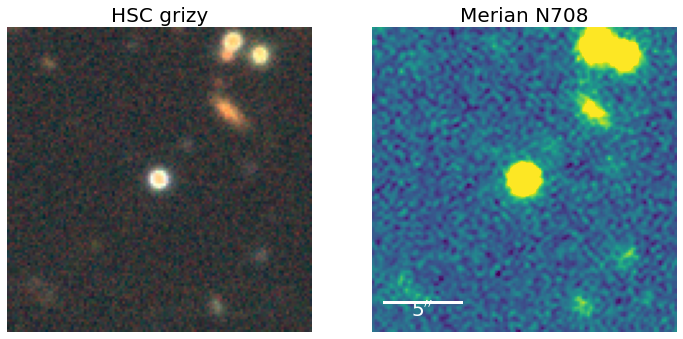

In [120]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(4)

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images[:4, ...],
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(hsc_data.images[-1], ax=ax2, pixel_scale=0.168)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

### `1832` i-band
    Detected 6 objects
# Total number of objects: 6
# Central object index in i-band: 0
# Progress: 1 / 6
# Progress: 2 / 6
# Progress: 3 / 6
# Progress: 4 / 6
# Progress: 5 / 6
# Progress: 6 / 6
# Global optimization: Chi2 improvement =  0.16106558


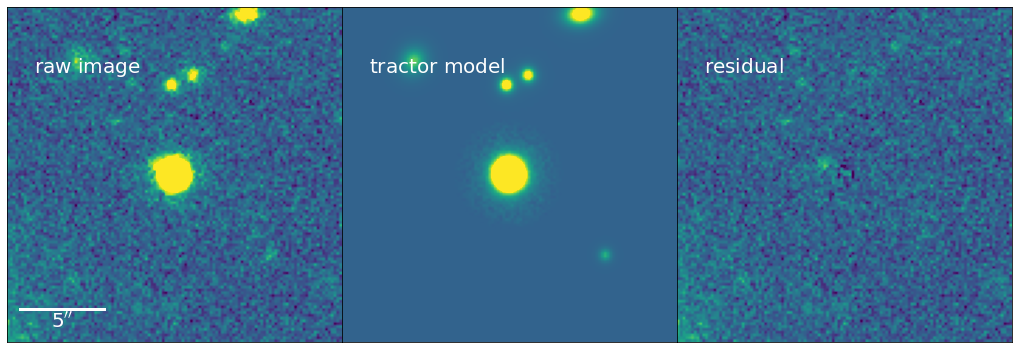

   The chi-square is 1.0799046
PointSource at pixel (58.78, 59.03) with Flux: 488.418


In [41]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    point_source=True,
    freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=True, show_fig=True)

### `1832` g-band
# Total number of objects: 6
# Central object index in g-band: 0
# Global optimization: Chi2 improvement =  62.82608


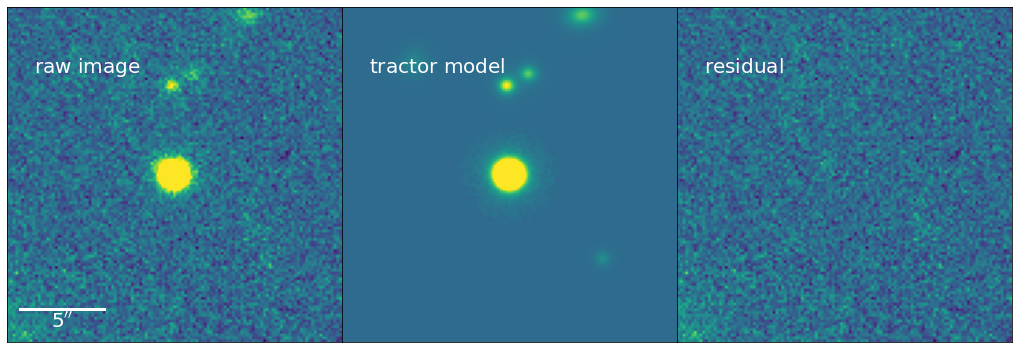

   The chi-square is 1.0013162
PointSource at pixel (58.79, 59.01) with Flux: 138.582


In [42]:
# Fix-all mode
model_dict['g'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'g', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True},  
    verbose=True, show_fig=True)

### `1832` N708-band
# Total number of objects: 6
# Central object index in N708-band: 0
# Global optimization: Chi2 improvement =  6.747984


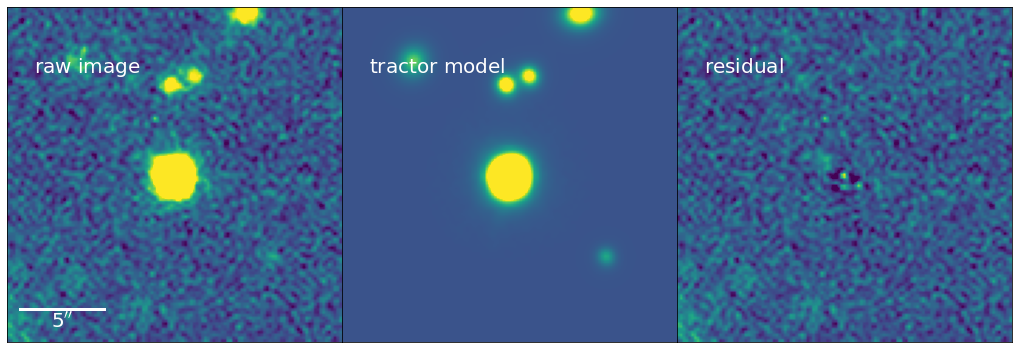

   The chi-square is 1.120622
PointSource at pixel (59.08, 58.46) with Flux: 434.223


In [43]:
# Fix-all mode
model_dict['N708'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N708', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

### `1832` N540-band
# Total number of objects: 6
# Central object index in N540-band: 0
# Global optimization: Chi2 improvement =  78.02547


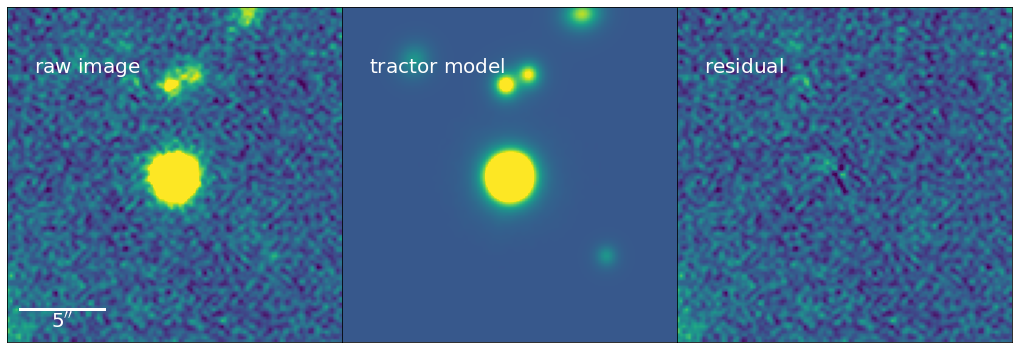

   The chi-square is 1.1037943
PointSource at pixel (59.13, 58.36) with Flux: 223.043


In [44]:
# Fix-all mode
model_dict['N540'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N540', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

In [45]:
-2.5 * np.log10(getTargetProperty(model_dict['g'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

1.367715837565845

In [57]:
obj['g_gaap_mag'] - obj['i_gaap_mag']

1.0991736691012974

In [23]:
2.5 * np.log10(getTargetProperty(model_dict['N708'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.10841265966749469

In [59]:
(obj['i_gaap_mag'] - obj['N708_gaap_mag'])

-0.09449710511459841

# Batch fitting (forced-photometry, blob-by-blob)

In [121]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row, getTargetProperty

### Tractor modeling for obj 0
### `7611` i-band
    Detected 10 objects
# Total number of objects: 10
# Central object index in i-band: 0
# Progress: 1 / 10
# Progress: 2 / 10
# Progress: 3 / 10
# Progress: 4 / 10
# Progress: 5 / 10
# Progress: 6 / 10
# Progress: 7 / 10
# Progress: 8 / 10
# Progress: 9 / 10
# Progress: 10 / 10
# Global optimization: Chi2 improvement =  0.68711746


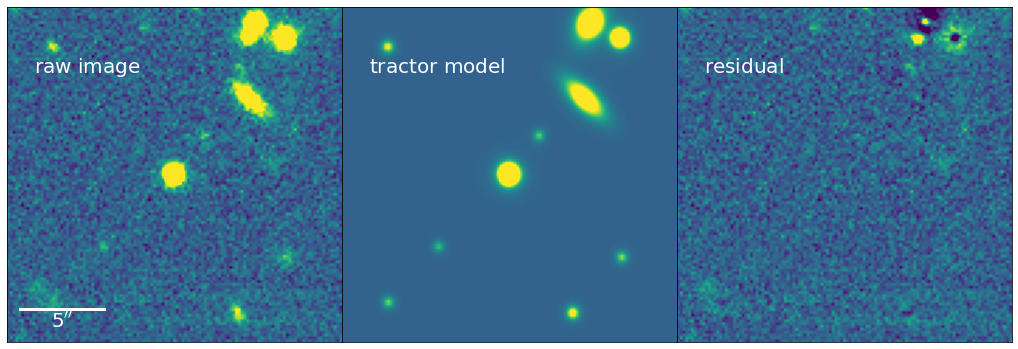

   The chi-square is 1.2498648
PointSource at pixel (58.78, 59.10) with Flux: 95.5058
### `7611` g-band
# Total number of objects: 10
# Central object index in g-band: 0
# Global optimization: Chi2 improvement =  2.4407415


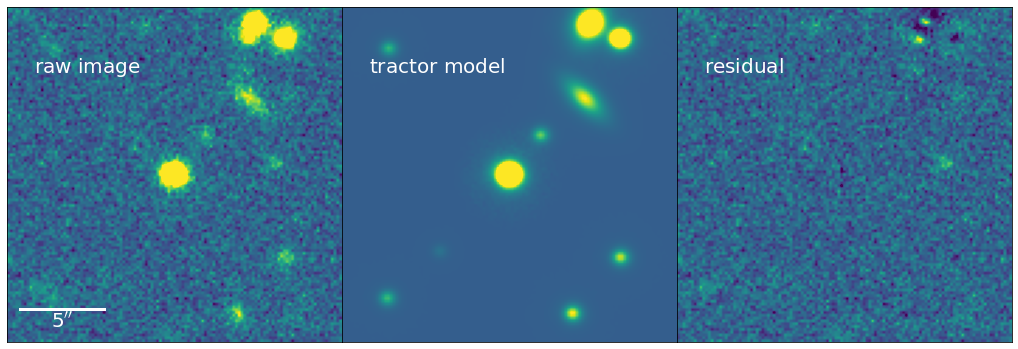

   The chi-square is 1.1789535
PointSource at pixel (58.77, 59.07) with Flux: 73.7615
### `7611` r-band
# Total number of objects: 10
# Central object index in r-band: 0
# Global optimization: Chi2 improvement =  0.34849298


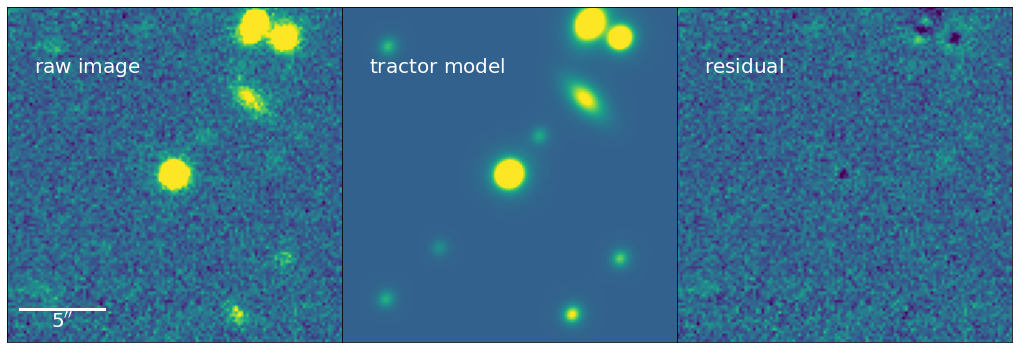

   The chi-square is 1.1465971
PointSource at pixel (58.76, 59.08) with Flux: 89.1474
### `7611` z-band
# Total number of objects: 10
# Central object index in z-band: 0
# Global optimization: Chi2 improvement =  0.025939703


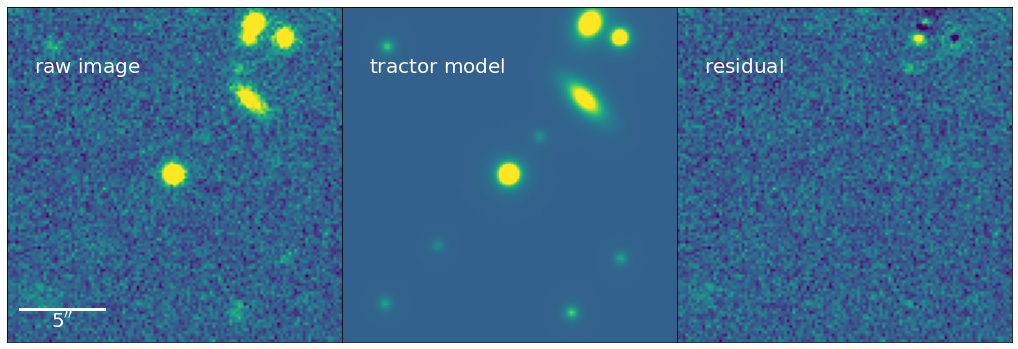

   The chi-square is 1.0998168
PointSource at pixel (58.76, 59.13) with Flux: 97.8486
### `7611` y-band
# Total number of objects: 10
# Central object index in y-band: 0
# Global optimization: Chi2 improvement =  0.062817276


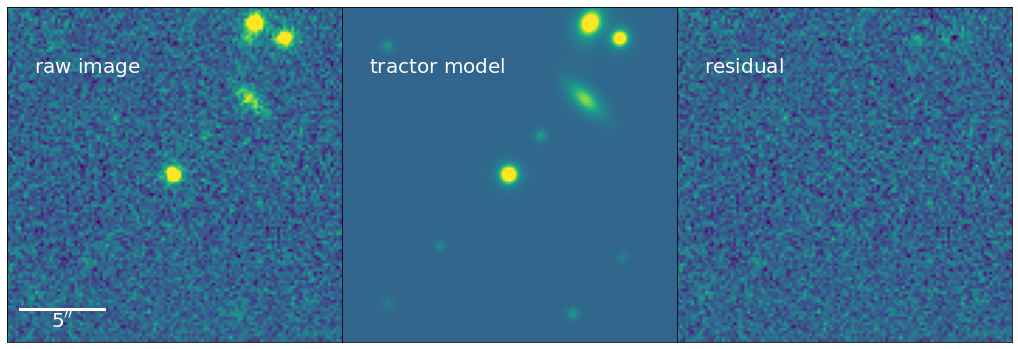

   The chi-square is 0.99536055
PointSource at pixel (58.74, 59.03) with Flux: 99.8126
### `7611` N708-band
# Total number of objects: 10
# Central object index in N708-band: 0
# Global optimization: Chi2 improvement =  0.44057894


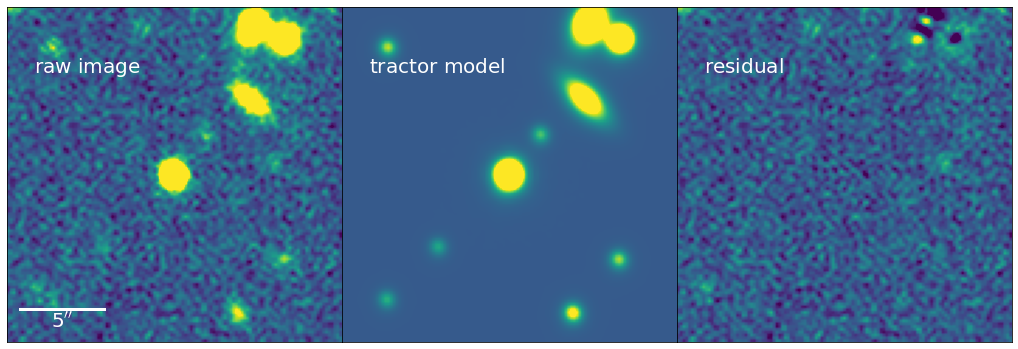

   The chi-square is 1.2125512
PointSource at pixel (58.81, 59.09) with Flux: 94.3755
### `7611` N540-band
# Total number of objects: 10
# Central object index in N540-band: 0
# Global optimization: Chi2 improvement =  1.6594762


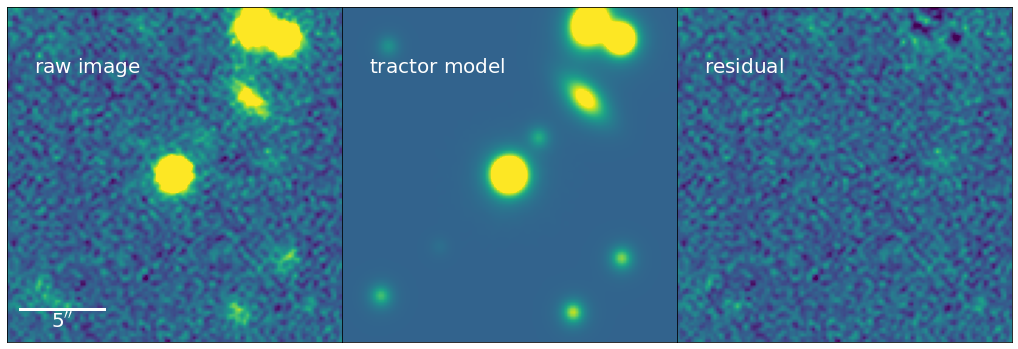

   The chi-square is 1.0442165
PointSource at pixel (58.82, 59.07) with Flux: 83.6996


In [122]:
channels = list('grizy') + ['N708', 'N540']
point_source=True

ref_filt = 'i'
forced_channels = [filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[10:10+1]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['id']
    
    cutout = []
    for filt in channels:
        if 'N' in filt:
            cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
        else:
            cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

    psf_list = []
    for filt in channels:
        if 'N' in filt:
            psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
        else:
            psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, data.channels, data, 
        point_source=point_source,
        freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                     'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=True, show_fig=True)
    
    for filt in forced_channels:
        pos = True
        fix_all = True
        ref_catalog = model_dict[ref_filt].catalog.copy()
        model_dict[filt], _ = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data,
            fix_all=fix_all, tractor_cat=ref_catalog,
            obj_cat=_obj_cat_i,
            # ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True,
                         'sersicindex': True},  # don't fix shape/sersic
            verbose=True, show_fig=True)
    with open(f'./cosmos_{obj["id"]}_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    # Write to catalog
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

---

In [61]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [123]:
from carpenter.display import display_merian_cutout_rgb

In [124]:
# Visualize our model
channels = list('griz') + ['N708', 'N540']
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([
        model_dict[key].getModelImage(
            0, srcs=model_dict[key].catalog[model_dict[key].target_ind:model_dict[key].target_ind+1]
                                     ) for key in channels])

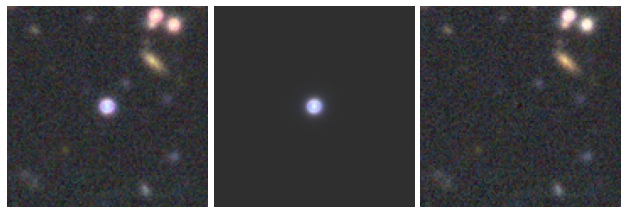

In [125]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(11, 5))

_img = np.vstack([data.images[0:4], data.images[-2:]])
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax1, color_norm=None, Q=1.5, stretch=0.8, 
                          channel_map=None, N708_strength=3);

_, _ = display_merian_cutout_rgb(model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax2, Q=1.5, stretch=0.8, 
                                 color_norm=None,
                                 channel_map=None);

_, _ = display_merian_cutout_rgb(_img - model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax3, Q=1.5, stretch=0.8, 
                                       color_norm=None,
                                       channel_map=None);

plt.subplots_adjust(wspace=0.03)

In [291]:
### SBP

In [126]:
gal = model_dict['i'].catalog[model_dict['i'].target_ind]

In [189]:
from photutils.isophote import Ellipse, EllipseGeometry
from photutils.aperture import EllipticalAperture

geometry = EllipseGeometry(x0=gal.pos.x, 
                           y0=gal.pos.y, 
                           sma=1, eps=0,
                           pa=0)
ellipse = Ellipse(model_img[-2], geometry)
isolist1 = ellipse.fit_image(sma0=10, minsma=0., integrmode='median', 
                            fix_center=False, fix_pa=True, fix_eps=True)

_mean_eps = np.mean(isolist1.eps[isolist1.sma > 20])
_mean_pa = np.mean(isolist1.pa[isolist1.sma > 20])
_mean_x = np.mean(isolist1.x0[isolist1.sma > 20])
_mean_y = np.mean(isolist1.y0[isolist1.sma > 20])

In [190]:
print(gal.pos.x, gal.pos.y)
print(_mean_x, _mean_y, _mean_eps, _mean_pa)

58.77925795211057 59.100999949080816
58.24194201365505 58.02686074560734 0.05 0.0


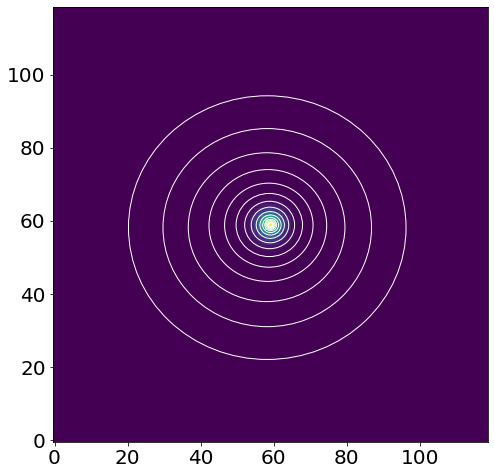

In [192]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(model_img[-2], origin='lower')
for iso in isolist1[1::3]:
    aper = EllipticalAperture((iso.y0, iso.x0), iso.sma,
                          iso.sma * (1 - iso.eps),
                          iso.pa)
    aper.plot(color='white')

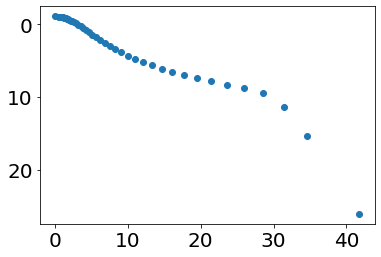

In [193]:
plt.scatter(isolist1.sma, -2.5*np.log10(isolist1.intens))

plt.gca().invert_yaxis()

    Detected 15 objects


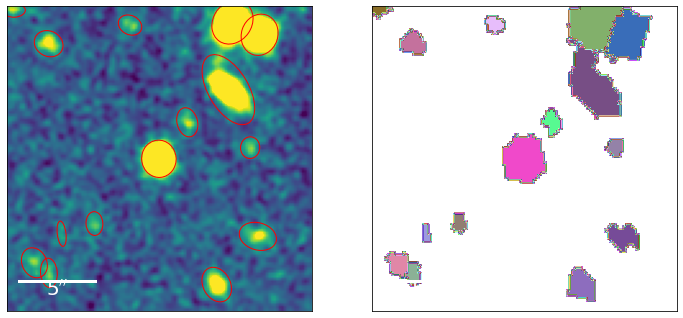

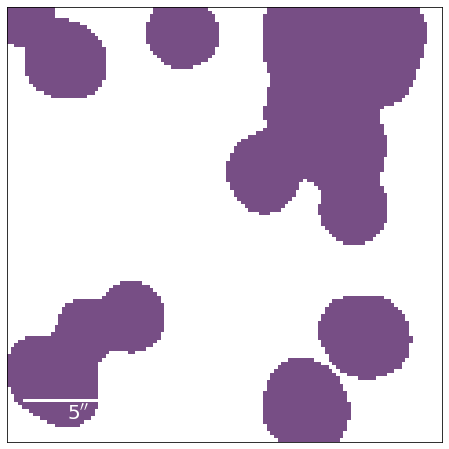

In [194]:
from kuaizi.detection import vanilla_detection
from astropy.convolution import convolve, Gaussian2DKernel
objcat, segmap, _ = vanilla_detection(data.images[-2], sigma=2, conv_radius=1, convolve=True)
cenid = segmap[segmap.shape[0] // 2, segmap.shape[1] // 2] - 1
segmap[segmap == (cenid + 1)] = 0.0

smooth_radius = 3
gaussian_threshold = 0.01
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
mask = (mask_conv >= gaussian_threshold)

display_single(mask.astype(float), cmap=SEG_CMAP, scale='linear');

In [195]:
geometry = EllipseGeometry(x0=_mean_x, y0=_mean_y, 
                           sma=5, eps=0,
                           pa=0)
ellipse = Ellipse(data.images[-2] * (~mask), geometry, threshold=0.001)
isolist = ellipse.fit_image(sma0=5, minsma=0, integrmode='median', nclip=3, 
                            maxgerr=5.,
                            fix_center=False, fix_eps=True, fix_pa=True)

# ellipse = Ellipse(model_img[0] * (~mask), geometry, threshold=0.001)
# isolist = ellipse.fit_image(sma0=10, minsma=1, fix_center=False, fix_pa=False, fix_eps=False)

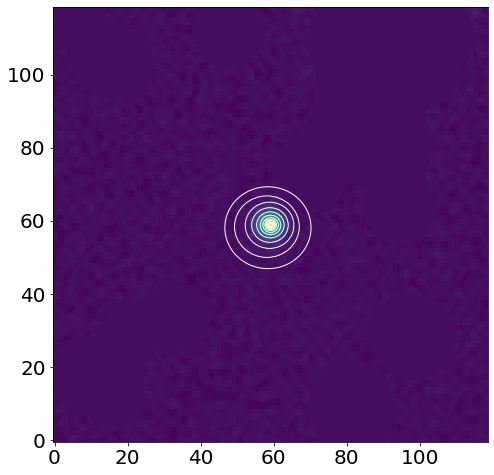

In [197]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(data.images[-2] * (~mask), origin='lower')
for iso in isolist[1::3]:
    aper = EllipticalAperture((iso.y0, iso.x0), iso.sma,
                          iso.sma * (1 - iso.eps),
                          iso.pa)
    aper.plot(color='white')

In [198]:
isolist.sma

array([ 0.        ,  0.50762799,  0.55839079,  0.61422987,  0.67565285,
        0.74321814,  0.81753995,  0.89929395,  0.98922334,  1.08814568,
        1.19696025,  1.31665627,  1.4483219 ,  1.59315409,  1.7524695 ,
        1.92771645,  2.12048809,  2.3325369 ,  2.56579059,  2.82236965,
        3.10460662,  3.41506728,  3.756574  ,  4.1322314 ,  4.54545455,
        5.        ,  5.5       ,  6.05      ,  6.655     ,  7.3205    ,
        8.05255   ,  8.857805  ,  9.7435855 , 10.71794405, 11.78973846,
       12.9687123 , 14.26558353])

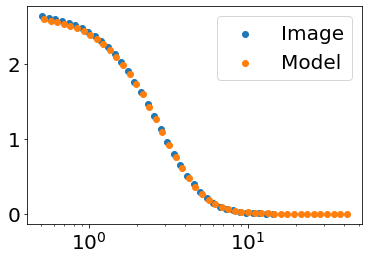

In [205]:
plt.scatter(isolist.sma[1:], isolist.intens[1:], label='Image')
plt.scatter(isolist1.sma[1:], isolist1.intens[1:], label='Model')
# plt.gca().invert_yaxis()

plt.xscale('log')
plt.legend()

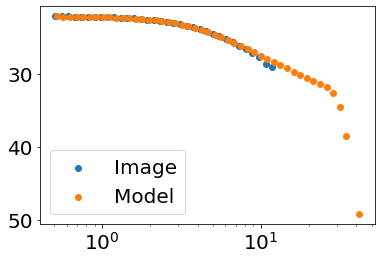

In [206]:
plt.scatter(isolist.sma[1:], -2.5*np.log10(isolist.intens[1:] / 0.168**2) + 27, label='Image')
plt.scatter(isolist1.sma[1:], -2.5*np.log10(isolist1.intens[1:] / 0.168**2) + 27, label='Model')
plt.gca().invert_yaxis()

plt.xscale('log')
plt.legend()

# plt.ylim(32, 21)

### Comparison

In [214]:
meas_cat = Table.read('./Catalogs/stars/tractor_stars_output_0_500.fits')

In [216]:
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'])

In [218]:
obj_cat = Table.read('./Cutout/stars/stars_obj_cat.fits')

In [219]:
channels = list('grizy') + ['N708', 'N540']

In [220]:
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    obj_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(obj_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [223]:
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=80)

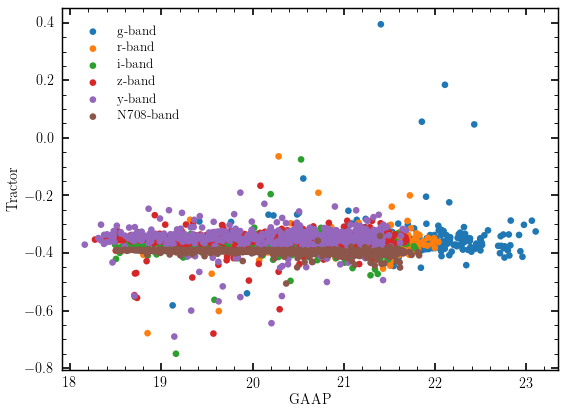

In [237]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(6):
    filt = channels[i]
    plt.scatter(obj_cat['gaap_mag_1p0'][:, i], obj_cat['gaap_mag_1p0'][:, i]- meas_cat['mag'][:, i], edgecolors='none',
                label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

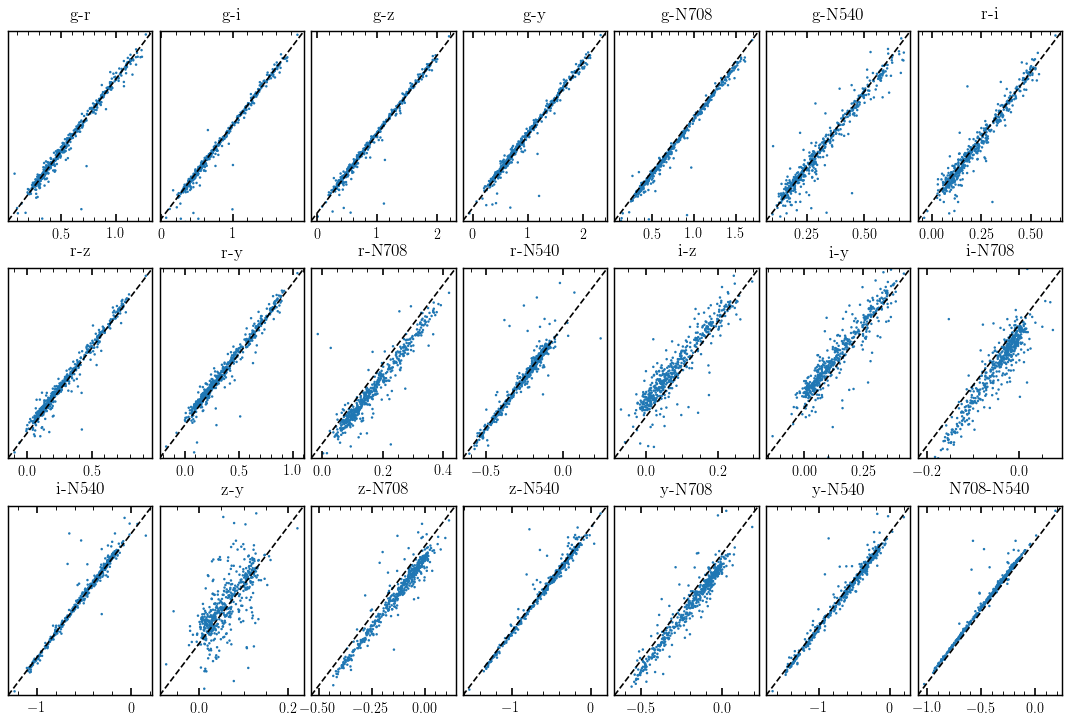

In [230]:
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11))

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = obj_cat[f'gaap_mag_{aper}'][:, filt1] - obj_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color2,
                s=5,
                label=aper, edgecolors='none')

    xlim = plt.gca().get_xlim()
    x = np.linspace(*xlim, 2)
    plt.plot(x, x, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.yticks([])
    plt.title(channels[filt1] + '-' + channels[filt2])
    
plt.subplots_adjust(wspace=0.05, hspace=0.25)
# axes[0, 0].set_ylabel('GAAP - tractor')

Text(0.5, 0.92, 'Stars')

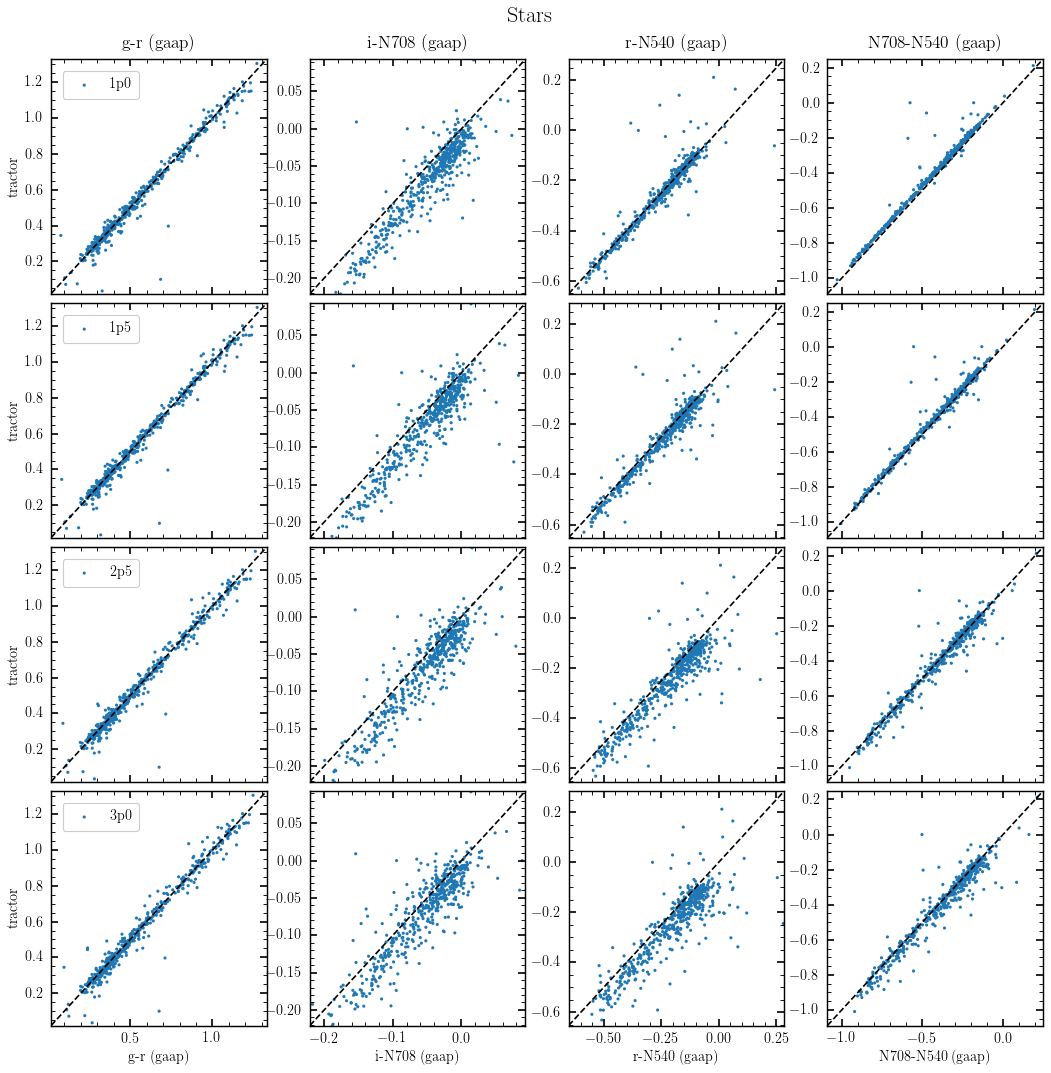

In [239]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex='col')

_filt = ((0, 1), (2, 5), (1, 6), (5, 6))

_apers = ['1p0', '1p5', '2p5', '3p0']

for k, aper in enumerate(_apers):
    for i in range(4):
        plt.sca(axes[k, i])
#         aper = '1p5'
        filt1, filt2 = _filt[i]
        color1 = obj_cat[f'gaap_mag_{aper}'][:, filt1] - obj_cat[f'gaap_mag_{aper}'][:, filt2]
        color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
        label = aper if i == 0 else None
        plt.scatter(color1, color2,
                    s=8,
                    label=label, edgecolors='none')

        xlim = plt.gca().get_xlim()
        x = np.linspace(*xlim, 2)
        plt.plot(x, x, color='k', ls='--')
        plt.xlim(*xlim)
        plt.ylim(*xlim)
        
        if i == 0:
            plt.legend(frameon=True)
        if k == 3:
            plt.xlabel(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
        if k == 0:
            plt.title(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
    axes[k, 0].set_ylabel('tractor')
    
plt.subplots_adjust(hspace=0.04)

plt.suptitle('Stars', y=0.92, fontsize=20)